Miniprojekt 3: Batch Gradient Descent mit Early Stopping für Softmax Regression
=

---

Dr.-Ing. Antje Muntzinger, Hochschule für Technik Stuttgart

antje.muntzinger@hft-stuttgart.de

---

In diesem Miniprojekt klassifizieren wir verschiedene Iris-Blumenarten mit Batch Gradient Descent. Wir implementieren dabei das Gradientenverfahren "von Hand" anstelle die Scikit-Learn-Implementierung zu verwenden, um genauer zu verstehen, wie die Optimierung der Parameter im Training erfolgt. 

Aufgabe 1: Setup und Daten
=

Den Iris-Datensatz haben wir bereits in der praktischen Übungsstunde kennengelernt. Wir laden hier die Daten und rufen uns die Datenstruktur ins Gedächtnis.

In [1]:
# install required packages specified in pipfile
!pipenv install

Installing dependencies from Pipfile.lock (d30d36)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.


Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.


In [2]:
# the usual imports
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [4]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [5]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [6]:
iris.target.head(3)  # note that the instances are not shuffled

0    0
1    0
2    0
Name: target, dtype: int64

In [7]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

**TODO**: 1a) Wieviele Attribute hat der Datensatz? Markieren Sie die korrekte Antwort mit [x] **(1 Punkt)**

**ANTWORT:**
- [ ] 2
- [ ] 3
- [X] 4
- [ ] 50
- [ ] 150
- [ ] 300
- [ ] 600

**TODO**: 1b) Wieviele verschiedene Labels hat der Datensatz? Markieren Sie die korrekte Antwort mit [x] **(1 Punkt)**

**ANTWORT:**
- [ ] 2
- [X] 3
- [ ] 4
- [ ] 50
- [ ] 150
- [ ] 300
- [ ] 600

**TODO**: 1c) Wieviele Samples hat der Datensatz? Markieren Sie die korrekte Antwort mit [x] **(1 Punkt)**

**ANTWORT:**
- [ ] 2
- [ ] 3
- [ ] 4
- [ ] 50
- [X] 150
- [ ] 300
- [ ] 600

Aufgabe 2: Training - Gradientenverfahren "von Hand"
=

Nun implementieren wir das Gradientenverfahren, um die Iris-Blumenarten zu klassifizieren. Wir benutzen dabei nur zwei Attribute und speichern die Daten in X (Features) und y (Labels):

In [8]:
# store features X and labels y
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

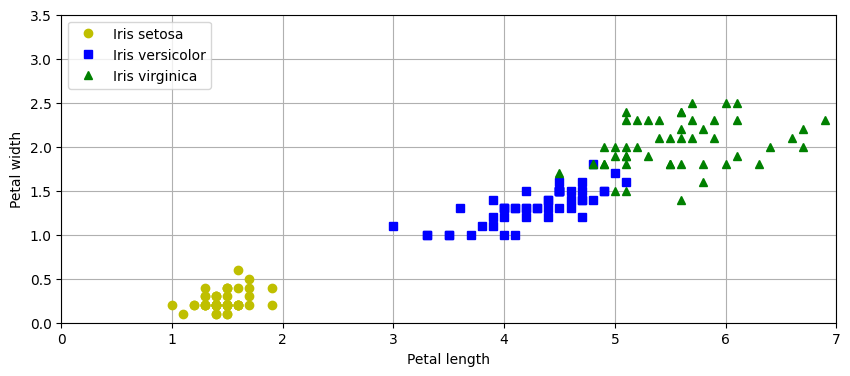

In [9]:
# plot the data
plt.figure(figsize=(10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")

plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

Wir müssen einen konstanten Bias-Term zu jedem Feature-Vektor hinzufügen ($x_0 = 1$). Die einfachste Möglichkeit ist, Scikit-Learn's Funktion `add_dummy_feature()` zu verwenden:

In [10]:
# add bias term
from sklearn.preprocessing import add_dummy_feature

X_with_bias = add_dummy_feature(X)  # add x0 = 1 to each instance (constant multiplier for bias)

Wir splitten die Daten `X_with_bias` und `y` in 80% Trainings-, 20% Validierungs- und 20% Testdaten. Dafür können wir zunächst `train_test_split` anwenden, um 20% der Daten als Testdaten zu speichern. Dann können wir `train_test_split` ein zweites Mal auf die 80% übrigen Daten anwenden, um 20% Validierungsdaten abzuspeichern. Beachten Sie, dass wir 25% von den 80% abspeichern müssen, um insgesamt 20% Validierungsdaten zu erhalten!

Achtung: Wir müssen Features und Labels immer gleichzeitig splitten, ansonsten passen die Werte nicht zusammen. Schauen Sie ggfs. in `Exercises_solution.ipynb`, dort haben wir einen ähnlichen Split angewandt. 

In [11]:
# split data in training, validation and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_with_bias, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

Die Labels sind momentan als Klassen-Indizes (0, 1 oder 2) gegeben, aber wir benötigen Klassenwahrscheinlichkeiten, um das Softmax-Regressionsmodell zu trainieren. Jede Instanz sollte Klassenwahrscheinlichkeiten = 0 für jede Klasse außer der tatsächlichen Klasse haben, die eine Wahrscheinlichkeit von 1 haben soll. In anderen Worten, die Klassenwahrscheinlichkeit jeder Instanz ist ein One-Hot-Vektor. Wir implementieren daher die Labels aller Daten als One-Hot-Encoding. Beachten Sie, dass die Scikit-Learn-Funktion ein 2D-Array als Input erwartet - wir transformieren daher auf ein 2D-Array mit einer Spalte. 

In [12]:
# one hot encoding 
from sklearn.preprocessing import OneHotEncoder

oneHotEncoding = OneHotEncoder(sparse_output=False)
Y_train_one_hot = oneHotEncoding.fit_transform(y_train.reshape(-1,1)) # function expects 2D array -> reshape
Y_valid_one_hot = oneHotEncoding.fit_transform(y_valid.reshape(-1,1))
Y_test_one_hot = oneHotEncoding.fit_transform(y_test.reshape(-1,1))

Jetzt skalieren wir die Inputs. Wir berechnen Mittelwert und Standardabweichung jedes Features auf den Trainingsdaten (außer dem Bias-Feature), dann mitteln und skalieren wir jedes Feature im Trainings-, Validierungs- und Testset:

In [13]:
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

Wir implementieren die Softmax-Funktion, die den Logit bzw. Score $\mathbf{s}(\mathbf{x})$ als Input bekommt und ein Array aus den folgenden Komponenten zurückgibt:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [14]:
# softmax function
def softmax(s):
    exp_s = np.exp(s)
    exp_sums = exp_s.sum(axis=1, keepdims=True)
    return exp_s / exp_sums

**TODO:** 2a) Wozu benötigen wir bei multinomialer logistischer Regression die Softmax-Funktion? Markieren Sie die korrekte(n) Antwort(en) mit [x] **(2 Punkte)**

**Antwort**: 
- [ ] Die Softmax-Funktion wird für Feature-Scaling verwendet, Werte zwischen 0 und 1 sind numerisch stabiler als sehr unterschiedliche Wertebereiche.
- [X] Die Softmax-Funktion transformiert die Scores / Logits in einen Wert in [0,1] und wir erhalten dadurch geschätzte Klassenwahrscheinlichkeiten.
- [ ] Die Softmax-Funktion ist fürs Training nicht nötig, sondern nur für die Inferenz-Pipeline, um Wahrscheinlichkeiten zu erhalten.
- [X] Die Softmax-Funktion wird verwendet, um exponentielle Kurven statt Geraden zu fitten.

Wir definieren die Anzahl Inputs und Outputs:

In [15]:
n_inputs = X_train.shape[1]  # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))  # == 3 (there are 3 iris classes)

Jetzt kommt der schwierigste Teil: Training! Der Code wurde hier ohne Scikit-Learn implementiert, um die einzelnen Schritte genauer nachvollziehen zu können. Wir implementieren die Loss-Funktion (Kostenfunktion):

$J(\mathbf{\Theta}) =- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

Die Gleichung für den Gradienten lautet:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Achtung: $\log\left(\hat{p}_k^{(i)}\right)$ ist nicht definiert für $\hat{p}_k^{(i)} = 0$. Daher fügen wir einen kleinen Wert $\epsilon$ zu $\log\left(\hat{p}_k^{(i)}\right)$ hinzu, um `nan`-Werte zu vermeiden.

**TODO**: 2b) Versuchen Sie, den folgenden Trainingscode nachzuvollziehen. Fügen Sie hinter jeder Code-Zeile einen Kommentar ein mit kurzer Erklärung, was diese Zeile tut! **(6 Punkte)**

In [16]:
##### TODO: Kommentieren Sie die Code-Zeilen in dieser Zelle
eta = 0.5 # learning rate for the tuning weights
n_epochs = 5001 # number of complete forward, backward props from beginning to the end  
m = len(X_train) # number of training data
epsilon = 1e-5 # small add up number to prevent some calculation errors maybe zero gradient

np.random.seed(42) # 
Theta = np.random.randn(n_outputs, n_inputs) # 

for epoch in range(n_epochs): # iteration over all epochs in order
    p_hat = softmax(np.dot(X_train, Theta)) # model prediction
    if epoch % 1000 == 0: # we want to print the loss every 1000 epoch
        p_hat_valid = softmax(np.dot(X_valid, Theta)) # prediction with using validation set
        xentropy_losses = -(Y_valid_one_hot * np.log(p_hat_valid + epsilon)) # calculating loss
        print(epoch, xentropy_losses.sum(axis=1).mean()) # printing epoch num and loss but we summed up and take mean of that loss because we calculate epoch by epoch
    error = p_hat - Y_train_one_hot # finding error with real label vs predicted label
    gradients = 1 / m * np.dot(X_train.T, error) # finding derivative for our loss
    Theta = Theta - eta * gradients # updating weight

0 3.363289917611154
1000 0.10012145308568764
2000 0.09200386789301372
3000 0.08990841614780502
4000 0.08915704630748893
5000 0.08885118045068427


**TODO**: 2c) Führen Sie den obigen Code aus. Was können Sie aus der Ausgabe der Fehler ablesen? Funktioniert das Training?  Markieren Sie die korrekte(n) Antwort(en) mit [x] **(2 Punkte)**

**Antwort**: 
- [ ] Der Testfehler ist klein, das Modell prädiziert also gut.
- [X] Der Validierungsfehler wird kleiner, das Modell konvergiert also und trainiert.
- [X] Der Code läuft fehlerfrei, das Modell funktioniert also.
- [X] Der Trainingsfehler wird kleiner, es könnte sich aber um Overfitting handeln.
- [ ] Der Fehler ist relativ groß und wird nicht kleiner, es scheint ein Bug vorhanden zu sein.

Schauen wir die Parameter an:

In [18]:
Theta

array([[-1.29653948,  5.55765886, -3.25498099],
       [-6.23348776, -0.88145239,  8.16967968],
       [-5.31247684,  0.7971185 ,  6.3925315 ]])

Wir prädizieren auf den Validierungsdaten und berechnen die Accuracy:

**TODO**: 2d) Berechnen Sie aus dem Score s unten die Klassenwahrscheinlichkeiten und speichern Sie das Ergebnis in `p_hat`. Geben Sie die prädizierten Klassenwahrscheinlichkeiten der ersten 5 Samples aus. **(2 Punkte)**

In [22]:
s = np.dot(X_valid, Theta) # score

##### TODO: HIER BITTE CODE EINGEBEN 
p_hat = softmax(s)

##### END STUDENT CODE

y_predict = p_hat.argmax(axis=1) 
print('y_predict[:5]=', y_predict[:5])

y_predict[:5]= [1 1 0 0 0]


**TODO**: 2e) Was bedeutet der Output der letzten Code-Zelle? Wie interpretieren Sie die Ausgabe? Markieren Sie die korrekte(n) Antwort(en) mit [x] **(2 Punkte)**

**ANTWORT:**
- [ ] `p_hat` beinhaltet die Prädiktionen, `y_predict` die tatsächlichen Labels. 
- [ ] `p_hat` beinhaltet in jeder Zeile die 3 Wahrscheinlichkeiten pro Instanz. `y_predict` ist das One-Hot-Encoding der Labels `y`.
- [X] `p_hat` beinhaltet in jeder Zeile die 3 prädizierten Klassenwahrscheinlichkeiten pro Sample. Die wahrscheinlichste Klasse wird dann in `y_predict` angezeigt (mit Klassennummer 0, 1 oder 2)
- [X] `p_hat` beinhaltet die transformierten Logits nach Anwenden der Softmax-Funktion. `y_predict` beinhaltet die finalen Prädiktionen auf den Testdaten.

**TODO**: 2f) Berechnen Sie die Accuracy auf dem Validierungsdatensatz und geben Sie das Ergebnis aus! **(1 Punkt)**

In [29]:
###### TODO: HIER BITTE CODE EINGEBEN 
y_valid[y_valid == y_predict].size / y_valid.size

0.9666666666666667

Aufgabe 3: Wahl der Lernrate
=

Hier erweitern wir den Trainingscode von oben und speichern ihn in einer Funktion. Wir experimentieren danach mit verschiedenen Lernraten und suchen eine zu kleine, eine zu große und eine passende Lernrate.

In [30]:
def run_training(eta):
    n_epochs = 5001
    m = len(X_train)
    epsilon = 1e-5
    
    np.random.seed(42)
    Theta = np.random.randn(n_inputs, n_outputs)
    
    epochs = []
    losses = []
    
    for epoch in range(n_epochs):
        p_hat = softmax(np.dot(X_train, Theta))
        if epoch % 100 == 0:
            p_hat_valid = softmax(np.dot(X_valid, Theta))
            xentropy_losses = -(Y_valid_one_hot * np.log(p_hat_valid + epsilon))
            total_loss = xentropy_losses.sum(axis=1).mean()
            print(epoch, total_loss.round(4))
            epochs.append(epoch)
            losses.append(total_loss)
        error = p_hat - Y_train_one_hot
        gradients = 1 / m * np.dot(X_train.T, error)
        Theta = Theta - eta * gradients

    return epochs, losses, X_valid, Theta


**TODO**: 3a) Experimentieren Sie mit verschiedenen Lernraten, indem Sie die Funktion `run_training()` mit unterschiedlichen Werten für `eta` aufrufen. Finden Sie zunächst eine zu kleine Lernrate, und plotten Sie die Rückgabewerte `losses` in Abhängigkeit der `epochs`. **(2 Punkte)**

0 3.3633
100 3.3633
200 3.3633
300 3.3633
400 3.3633
500 3.3633
600 3.3633
700 3.3633
800 3.3633
900 3.3633
1000 3.3633
1100 3.3633
1200 3.3633
1300 3.3633
1400 3.3633
1500 3.3633
1600 3.3633
1700 3.3633
1800 3.3633
1900 3.3633
2000 3.3633
2100 3.3633
2200 3.3633
2300 3.3633
2400 3.3633
2500 3.3633
2600 3.3633
2700 3.3633
2800 3.3633
2900 3.3633
3000 3.3633
3100 3.3633
3200 3.3633
3300 3.3633
3400 3.3633
3500 3.3633
3600 3.3633
3700 3.3633
3800 3.3633
3900 3.3633
4000 3.3633
4100 3.3633
4200 3.3633
4300 3.3633
4400 3.3633
4500 3.3633
4600 3.3633
4700 3.3633
4800 3.3633
4900 3.3633
5000 3.3633


Text(0, 0.5, 'loss')

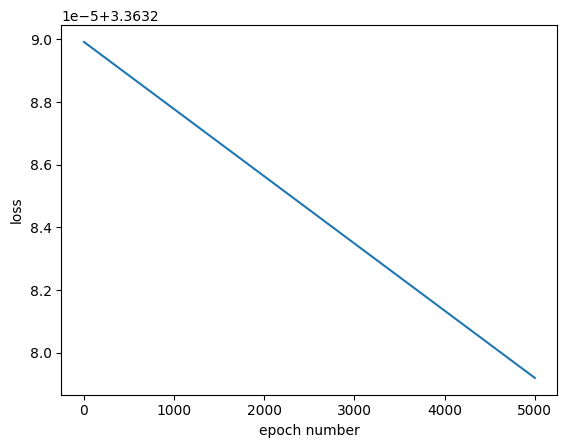

In [33]:
##### TODO: HIER BITTE CODE EINGEBEN 
epochs_, losses_, X_valid_, theta_ = run_training(0.000000001)

plt.plot(epochs_, losses_)
plt.xlabel("epoch number")
plt.ylabel("loss")

**TODO**: 3b) Woran sehen Sie, dass die Lernrate zu klein ist? Würden weitere Trainingszyklen helfen? **(2 Punkte)**

**Antwort**: Loss decreases very slow so it will take so much time to learn this model. Maybe tons of more epochs would help.

**TODO**: 3c) Finden Sie jetzt eine zu große Lernrate, und plotten Sie wieder die Rückgabewerte `losses` in Abhängigkeit der `epochs`. **(2 Punkte)**

0 3.3633
100 0.0879
200 0.0883
300 0.0885
400 0.0885
500 0.0886
600 0.0886
700 0.0886
800 0.0886
900 0.0886
1000 0.0886
1100 0.0886
1200 0.0886
1300 0.0886
1400 0.0886
1500 0.0886
1600 0.0886
1700 0.0886
1800 0.0886
1900 0.0886
2000 0.0886
2100 0.0886
2200 0.0886
2300 0.0886
2400 0.0886
2500 0.0886
2600 0.0886
2700 0.0886
2800 0.0886
2900 0.0886
3000 0.0886
3100 0.0886
3200 0.0886
3300 0.0886
3400 0.0886
3500 0.0886
3600 0.0886
3700 0.0886
3800 0.0886
3900 0.0886
4000 0.0886
4100 0.0886
4200 0.0886
4300 0.0886
4400 0.0886
4500 0.0886
4600 0.0886
4700 0.0886
4800 0.0886
4900 0.0886
5000 0.0886


Text(0, 0.5, 'loss')

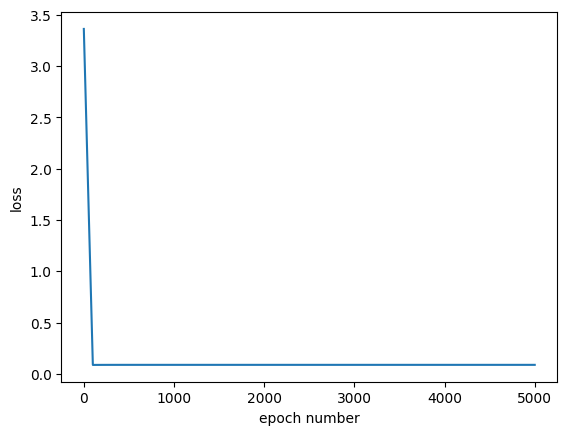

In [35]:
##### TODO: HIER BITTE CODE EINGEBEN 
epochs_, losses_, X_valid_, theta_ = run_training(10)

plt.plot(epochs_, losses_)
plt.xlabel("epoch number")
plt.ylabel("loss")

**TODO**: 3d) Woran sehen Sie, dass die Lernrate zu groß ist? Würden weitere Trainingszyklen helfen? **(2 Punkte)**

**Antwort**: Loss directly goes down and it overfit completely. More epoch makes no difference as you can see.

**TODO**: 3e) Finden Sie schließlich eine passende Lernrate, und plotten Sie die Rückgabewerte `losses` in Abhängigkeit der `epochs`. **(2 Punkte)**

0 3.3633
100 1.6596
200 1.0118
300 0.816
400 0.7236
500 0.6634
600 0.6177
700 0.5807
800 0.5494
900 0.5225
1000 0.499
1100 0.4781
1200 0.4595
1300 0.4427
1400 0.4274
1500 0.4135
1600 0.4008
1700 0.3891
1800 0.3783
1900 0.3682
2000 0.3589
2100 0.3502
2200 0.3421
2300 0.3345
2400 0.3273
2500 0.3206
2600 0.3142
2700 0.3082
2800 0.3025
2900 0.2971
3000 0.292
3100 0.2871
3200 0.2825
3300 0.278
3400 0.2738
3500 0.2698
3600 0.2659
3700 0.2622
3800 0.2587
3900 0.2553
4000 0.252
4100 0.2489
4200 0.2459
4300 0.243
4400 0.2402
4500 0.2375
4600 0.2348
4700 0.2323
4800 0.2299
4900 0.2276
5000 0.2253


Text(0, 0.5, 'loss')

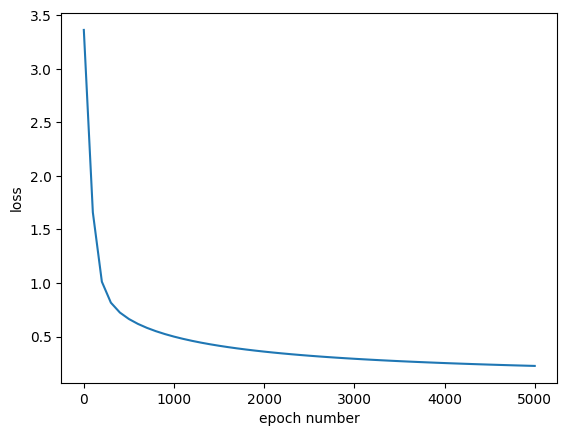

In [36]:
##### TODO: HIER BITTE CODE EINGEBEN 
epochs_, losses_, X_valid_, theta_ = run_training(0.01)

plt.plot(epochs_, losses_)
plt.xlabel("epoch number")
plt.ylabel("loss")

**TODO**: 3f) Woran sehen Sie, dass die Lernrate passend ist? **(2 Punkte)** 

**Antwort**: Loss goes down stable and the decrease rate is getting lower every iteration. So we are finding the global minima very well. It is the optimal learning rate.

Aufgabe 4: Regularisierung - Early Stopping
=

**TODO**: 4a) Nach wie vielen `epochs` kann man das Training mit Ihrer besten Lernrate oben etwa abbrechen? Begründen Sie! **(2 Punkte)**

**Antwort**: If the loss starts to go upwards then I can stop. For now maybe after 6000-7000 because there is still approximately 0.3 loss.

**TODO**: 4b) Jetzt implementieren Sie Early Stopping. Dazu berechnen Sie den Loss auf den Validierungsdaten in jeder Iteration und brechen ab, sobald der Fehler wieder ansteigt. Speichern Sie in jeder Iteration den bisher kleinsten Loss in `best_loss` und vergleichen ihn mit dem aktuellen Loss. Implementieren Sie auch eine Ausgabe, bei welchem Loss in welcher Epoche abgebrochen wird. **(4 Punkte)**

In [40]:
eta = 0.5
n_epochs = 50_001
m = len(X_train)
epsilon = 1e-5
best_loss = np.inf

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    s = np.dot(X_train, Theta)
    p_hat = softmax(s)
    p_hat_valid = softmax(np.dot(X_valid, Theta))
    xentropy_losses = -(Y_valid_one_hot * np.log(p_hat_valid + epsilon))
    total_loss = xentropy_losses.sum(axis=1).mean()
    if epoch % 100 == 0:
        print(epoch, total_loss.round(4))
        
    ##### TODO: BITTE HIER CODE EINGEBEN
    if best_loss >= total_loss:
        best_loss = total_loss
    else:
        print(f"{epoch}. epoch loss is increased we are stopping, loss = {total_loss} | best_loss {best_loss}")
        break
  

    ##### END STUDENT CODE
    error = p_hat - Y_train_one_hot
    gradients = 1 / m * np.dot(X_train.T, error)
    Theta = Theta - eta * gradients

0 3.3633
100 0.2234
200 0.1625
300 0.1385
400 0.1255
500 0.1173
600 0.1116
700 0.1075
800 0.1045
900 0.102
1000 0.1001
1100 0.0986
1200 0.0973
1300 0.0962
1400 0.0953
1500 0.0945
1600 0.0939
1700 0.0933
1800 0.0928
1900 0.0924
2000 0.092
2100 0.0917
2200 0.0914
2300 0.0911
2400 0.0909
2500 0.0907
2600 0.0905
2700 0.0903
2800 0.0902
2900 0.09
3000 0.0899
3100 0.0898
3200 0.0897
3300 0.0896
3400 0.0895
3500 0.0894
3600 0.0894
3700 0.0893
3800 0.0893
3900 0.0892
4000 0.0892
4100 0.0891
4200 0.0891
4300 0.089
4400 0.089
4500 0.089
4600 0.0889
4700 0.0889
4800 0.0889
4900 0.0889
5000 0.0889
5100 0.0888
5200 0.0888
5300 0.0888
5400 0.0888
5500 0.0888
5600 0.0888
5700 0.0887
5800 0.0887
5900 0.0887
6000 0.0887
6100 0.0887
6200 0.0887
6300 0.0887
6400 0.0887
6500 0.0887
6600 0.0887
6700 0.0887
6800 0.0887
6900 0.0887
7000 0.0887
7100 0.0887
7200 0.0887
7300 0.0887
7400 0.0887
7500 0.0887
7600 0.0887
7700 0.0887
7800 0.0887
7900 0.0886
8000 0.0886
8100 0.0886
8200 0.0886
8300 0.0886
8400 0.0886

**TODO**: 4c) Überprüfen Sie, ob die Accuracy sich mit Early Stopping verschlechtert hat! **(1 Punkt)**

In [42]:
###### TODO: HIER BITTE CODE EINGEBEN 
y_predict = p_hat_valid.argmax(axis=1)
y_valid[y_valid == y_predict].size / y_valid.size

0.9666666666666667

Jetzt plotten wir die Prädiktionen des Modells auf dem ganzen Datensatz (Achtung, alle Features müssen vor Input wie oben auf Mittelwert 0 und Standardabweichung 1 skaliert werden!)

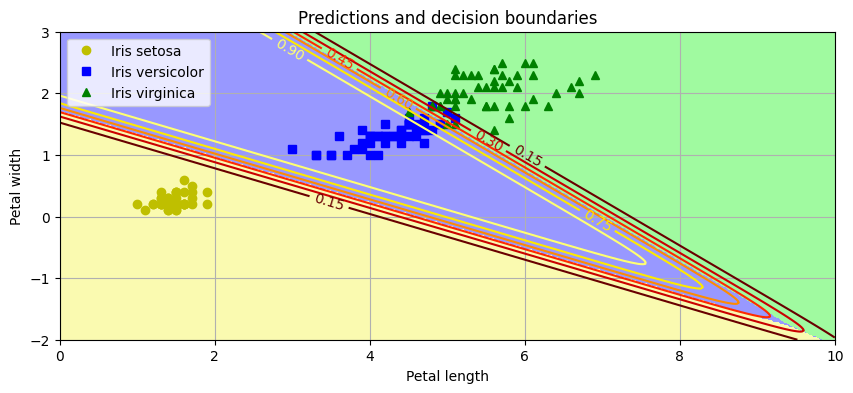

In [43]:
custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

xlim0, xlim1, ylim0, ylim1 = 0, 10, -2, 3 

x0, x1 = np.meshgrid(np.linspace(xlim0, xlim1, 500).reshape(-1, 1),
                     np.linspace(ylim0, ylim1, 200).reshape(-1, 1))

X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = add_dummy_feature(X_new)  # add x0 = 1 to each instance (constant multiplier for bias)

logit = np.dot(X_new_with_bias, Theta)
p_hat = softmax(logit)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")

# color areas with predicted class 
y_predict = p_hat.argmax(axis=1) # get maximum of 3 class probs for each mesh point = prediction
y_predict_reshaped = y_predict.reshape(x0.shape)
plt.contourf(x0, x1, y_predict_reshaped, cmap=custom_cmap)

# plot contour lines with probs for 2nd class (iris versicolor)
p_hat_1_reshaped = p_hat[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, p_hat_1_reshaped, cmap="hot")
plt.clabel(contour, inline=1)

plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([xlim0, xlim1, ylim0, ylim1])
plt.grid()
plt.title("Predictions and decision boundaries")
plt.show()

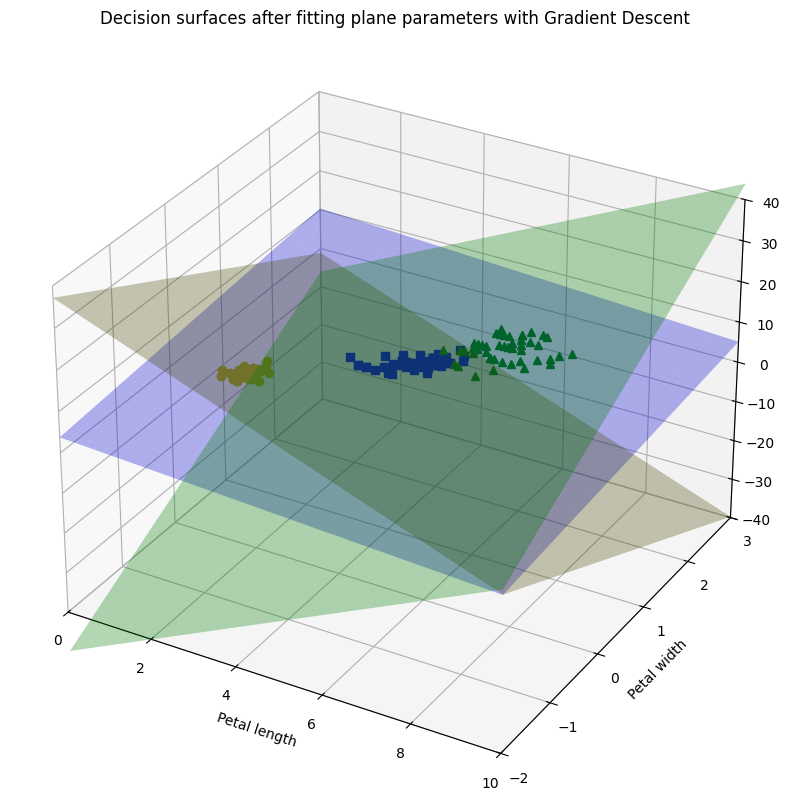

In [44]:
# plot surface map using meshgrid
from matplotlib import cm

plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

logit0_reshaped = logit[:,0].reshape(x0.shape)
ax.plot_surface( x0, x1, logit0_reshaped, alpha = 0.3, color='y')
logit1_reshaped = logit[:,1].reshape(x0.shape)
ax.plot_surface( x0, x1, logit1_reshaped, alpha = 0.3, color='b')
logit2_reshaped = logit[:,2].reshape(x0.shape)
ax.plot_surface( x0, x1, logit2_reshaped, alpha = 0.3, color='g')

plt.plot(X[y == 0, 0], X[y == 0, 1], 0, "yo", label="Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], 0, "bs", label="Iris versicolor")
plt.plot(X[y == 2, 0], X[y == 2, 1], 0, "g^", label="Iris virginica")

  
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([xlim0, xlim1, ylim0, ylim1, -40, 40])
plt.title("Decision surfaces after fitting plane parameters with Gradient Descent")
plt.show()


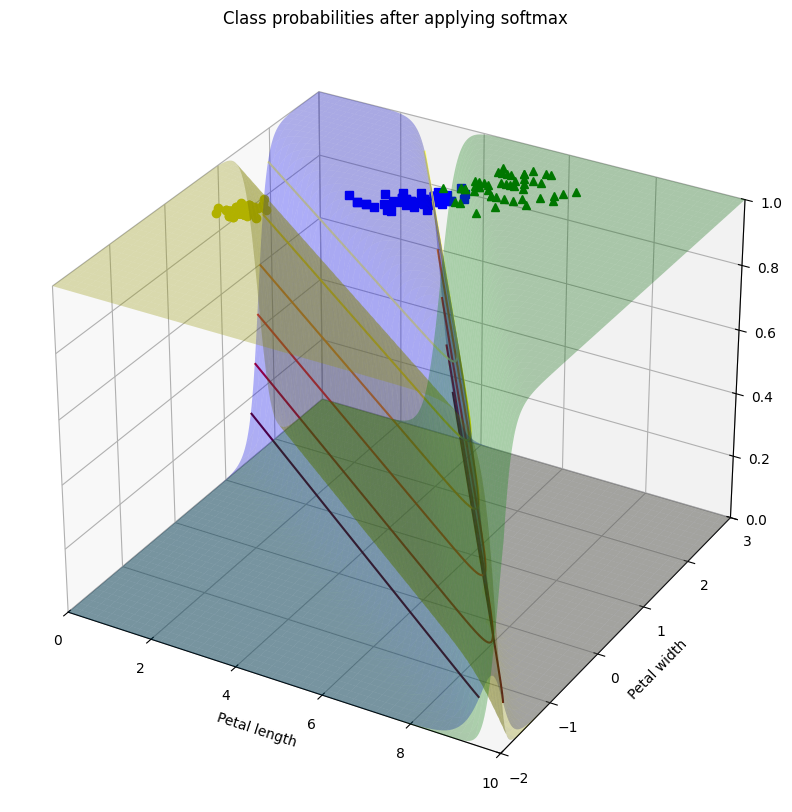

In [45]:
# plot surface map using meshgrid
from matplotlib import cm

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

p_hat0_reshaped = p_hat[:,0].reshape(x0.shape)
ax.plot_surface( x0, x1, p_hat0_reshaped, alpha = 0.3, color='y')
p_hat1_reshaped = p_hat[:,1].reshape(x0.shape)
ax.plot_surface( x0, x1, p_hat1_reshaped, alpha = 0.3, color='b')
p_hat2_reshaped = p_hat[:,2].reshape(x0.shape)
ax.plot_surface( x0, x1, p_hat2_reshaped, alpha = 0.3, color='g')

plt.plot(X[y == 0, 0], X[y == 0, 1], 1, "yo", label="Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], 1, "bs", label="Iris versicolor")
plt.plot(X[y == 2, 0], X[y == 2, 1], 1, "g^", label="Iris virginica")

contour = plt.contour(x0, x1, p_hat_1_reshaped, cmap="hot")
  
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([xlim0, xlim1, ylim0, ylim1, 0, 1])
plt.title("Class probabilities after applying softmax")
plt.show()


**TODO**: 4d) Berechnen Sie die finale Accuracy auf den Testdaten! **(2 Punkte)**

In [47]:
###### TODO: HIER BITTE CODE EINGEBEN 
p_test = softmax(np.dot(X_test, Theta))
y_predict_test = p_test.argmax(axis=1)
acc = y_test[y_test == y_predict_test].size / y_test.size
print(f"Accuracy: %{acc*100}")

Accuracy: %100.0


Gegebenenfalls bekommen Sie sogar ein besseres Ergebnis als auf den Validierungsdaten! Dies liegt an dem sehr kleinen Datensatz, wodurch es zu zufälligen Schwankungen kommt. Sie können es ausprobieren, indem Sie einen anderen Wert für `random_seed` wählen.